In [1]:
# All Required Imports
import os
import numpy as np
import scipy.io as io
from PIL import Image
import matplotlib.pyplot as plt
import cv2

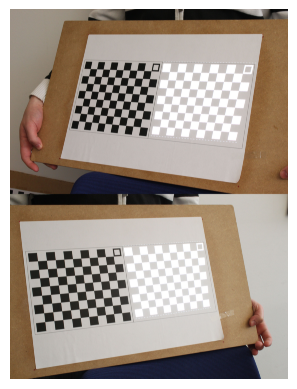

In [2]:
def show_img(img):
    fig_1 = plt.figure(figsize=(10,10))
    ax_1 = fig_1.add_subplot(111)
    ax_1.imshow(img)
    plt.show()

os.makedirs(f'./results', exist_ok=True)

#Read Images
image_0=cv2.imread('data/Camera00.jpg')
image_0=cv2.cvtColor(image_0,cv2.COLOR_BGR2RGB)
image_1=cv2.imread('data/Camera01.jpg')
image_1=cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)

# Load kmatrices and pose data
data = io.loadmat('data/data.mat')

k_0, k_1 = data['K_0'], data['K_1']
r_1, t_1 = data['R_1'], data['t_1']

# Load chessboard corners
corners_cam_0 = np.asarray(data['cornersCam0'], dtype=np.float32)
corners_cam_1 = np.asarray(data['cornersCam1'], dtype=np.float32)
imgs=np.vstack((image_0,image_1))
plt.axis('off')
plt.imshow(imgs)
plt.show()

Calculating Fundamental Matrix

In [3]:
# The formula for Fundamental Matrix is a matrix multiplication between inverse transpose of k1 with skewed Translation Matrix with Rotation Matrix and inverse of k0 matrix

k1_inverse=np.linalg.inv(k_1)                                                                                       # Getting the inverse of k1 matrix
k1_inverse_transpose=np.transpose(k1_inverse)                                                                       # Getting the transpose of the inverse of k1

k0_inverse=np.linalg.inv(k_0)                                                                                       # Getting the inverse of k0 matrix

translation_matrix=np.array(([0,-t_1[0,2],t_1[0,1]],[t_1[0,2],0,-t_1[0,0]],[-t_1[0,1],t_1[0,0],0])).reshape(3,3)    # Converting the translation matrix into skew translation matrix
Fundamental_matrix=k1_inverse_transpose@translation_matrix@r_1@k0_inverse                                           # Multiplying the matrices to get Fundamental Matrix
display("Fundamental Matrix (F)",Fundamental_matrix)

'Fundamental Matrix (F)'

array([[ 4.32613079e-08, -2.94957444e-07,  3.09417880e-04],
       [-7.85225041e-07, -1.44160167e-07, -7.12492588e-03],
       [-3.02634033e-04,  9.77268861e-03, -4.88854107e-02]])

Point matching between Images

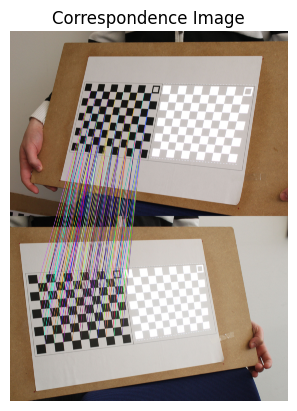

In [4]:
one_dimensional=np.array(1).reshape(1,1)                                                                            # Initialising the value of 1
w,h = image_1.shape[0],image_1.shape[1]                                                                             # Finding the shape of the image

# Need to add the height factor because these 2 images are stacked in 1 and we need to consider the height of the first image
height=np.array([0,w]).reshape(1,2)                                                                                                                             # Initialising the height variable

# For finding the point correspondences we need to check the condition of x1_transpose.Fundamental Matrix.x0=0
# Checking the point correspondences & Plotting the lines on the image
for i in range (len(corners_cam_0)):
    x1=corners_cam_0[i,:]
    x1=x1.reshape(2,1)
    x1=np.vstack((x1,one_dimensional))

    for j in range (len(corners_cam_1)):
        x1_prime=corners_cam_1[j,:]
        x1_prime=x1_prime.reshape(1,2)
        x1_prime_transpose=np.hstack((x1_prime,one_dimensional))
        color=tuple(np.random.randint(0,255,3).tolist())                                                                                                        # Since we need multiple colors creating a color variable to give random color to each line
       
        # Creating an output matrix consisting of all the output values after matrix multiplication
        if j == 0:
            output= x1_prime_transpose@Fundamental_matrix@x1                                                                                                    # Matrix multiplication between x1_transpose, Fundamental Matrix & x0
        else:
            output1=x1_prime_transpose@Fundamental_matrix@x1                                                                                                    # Matrix multiplication between x1_transpose, Fundamental Matrix & x0
            output=np.append(output,output1)                                                                                                                    # Concatenating the ouptut for each point to an output matrix
    
    # Finding the values nearest to zero.
    # If we convert the values of output directly from float variable to int variable will cause a problem because many outputs have a value close to 0.
    # As a result the output value which has the value closest to 0 will be the point correspondence.
    nearest_to_0=np.absolute(output)                                                                                                                            # Finds the value nearest to 0 in the list
    index=nearest_to_0.argmin()                                                                                                                                 # Finds the index of the point closest to 0
    
    # Creating a matrix of the point correspondences to a matrix to so that we can use those points to plot the points in 3D space
    if i == 0:
        correspondence_corners=[corners_cam_1[index,:]]
    else:
        correspondence_corners1=[corners_cam_1[index,:]]
        correspondence_corners=np.append(correspondence_corners,correspondence_corners1,axis=0)
    correspondence_image=cv2.line(imgs,(int(corners_cam_0[i,0]),(int(corners_cam_0[i,1]))),(int(corners_cam_1[index,0]),int(corners_cam_1[index,1]+w)),color,5) # Plots lines on the image
plt.axis('off')
plt.title("Correspondence Image")
plt.imshow(correspondence_image)
plt.savefig('results/matches.jpg',)
plt.show()

Converting the Point matched points into 3D Space (World coordinates)

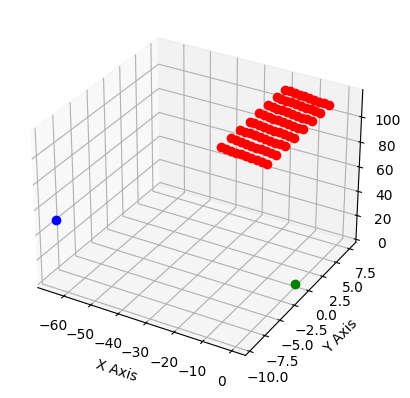

In [5]:
ax=plt.axes(projection="3d")                                                                                        # Stating that the plot will be a 3D plot instead of a 2D plot                                                       
zero_dimensional=np.array([0,0,0]).reshape(3,1)

# P1 = K1[I|0] where I = Identity Matrix & 0 = 0 Matrix
P1=np.hstack((k_0,zero_dimensional))                                                                                

# P2 = K2[R|t] where R = Rotation Matrix & t = translation matrix
Rotation_translation=np.hstack((r_1,t_1.T))                                                                         # Finding [R|t]                                                             
P2=k_1@Rotation_translation                                                                                         # Calculating P2 by multiplying K2 with [R|t]

# Computing & Projecting the points in a 3D space
# Using the formula x1=x0.P3-P1 & y1=y0.P3-P2
# where x0= initial value of x, x1 is the final value of x, y0 is the initial value of y, y1 is the final value of y
# where P3 is the 3rd row of Projection Matrix, similarly P2 & P1 are the 2nd and the 1st row of the Projection matrix respectively
for i in range(len(corners_cam_0)):
    x0=(corners_cam_0[i,0]*P1[2,:])-P1[0,:]                                                                        
    y0=(corners_cam_0[i,1]*P1[2,:])-P1[1,:]
    x1=(correspondence_corners[i,0]*P2[2,:])-P2[0,:]
    y1=(correspondence_corners[i,1]*P2[2,:])-P2[1,:]
    point=np.array([x0,y0,x1,y1]).reshape(4,4)                                                                      # Concatenating all the values of x & y in a single matrix

    u,a,v=np.linalg.svd(point)                                                                                      # Performing SVD to get the final x,y,z coordinates of the point
    # The 3rd row of the v matrix calcualted from SVD gives us the image coordinates in homogeneous coordinates
    # Dividing the 4th term of the row with the rest of the terms converts the coordinates from homogeneous coordinates system to world coordinate system
    x=v[3,0]/v[3,3]                                                                                                 
    y=v[3,1]/v[3,3]
    z=v[3,2]/v[3,3]
    ax=plt.plot(x,y,z,color='red',marker='o')                                                                       # Plotting the points

# Considering the camera in image 0 be the origin
Optical_Centre_cam_0=np.array([0,0,0]).reshape(3,1)
plt.plot(Optical_Centre_cam_0[0,0],Optical_Centre_cam_0[1,0],Optical_Centre_cam_0[2,0],color='green',marker='o')    # Plotting the points

# Trying to find the Optical Centre of 2nd Camera
# Using the formula; matrix multiplication of -ve of transpose of R with the T
# where R is the rotation matrix and T is the translation matrix
Optical_Centre_cam_1=-r_1.T@t_1.T
plt.plot(Optical_Centre_cam_1[0,0],Optical_Centre_cam_1[1,0],Optical_Centre_cam_1[2,0],color='blue',marker='o')     # Plotting the points
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()